
# Binary Classification Using a Bank Churn Dataset

## Introduction

In this notebook, we will explore a binary classification problem to predict customer churn for a bank. The goal is to develop a robust model that can accurately identify customers who are likely to leave the bank, enabling the bank to proactively address their needs and retain them.

The dataset we will be using contains information about bank customers, including their demographic characteristics, account details, and whether they have churned or not. Our objective is to build a machine learning model that can accurately predict the likelihood of a customer churning based on the available features.

In [20]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and evaluation
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Inline plotting
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


## Exploratory Data Analysis

Before we dive into the modeling process, it's important to understand the characteristics of the dataset. We will start by exploring the data, looking for patterns, trends, and potential relationships between the features and the target variable (Exited).

In [3]:
# Load data 
data = pd.read_csv('train.csv.zip')

data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [5]:
# Changing the data types based on the column names and what they represent
data['id'] = data['id'].astype(str)
data['CustomerId'] = data['CustomerId'].astype(str)
data['Geography'] = data['Geography'].astype('category')
data['Gender'] = data['Gender'].astype('category')

# Drop the 'Surname' column
data = data.drop(['Surname'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   id               165034 non-null  object  
 1   CustomerId       165034 non-null  object  
 2   CreditScore      165034 non-null  int64   
 3   Geography        165034 non-null  category
 4   Gender           165034 non-null  category
 5   Age              165034 non-null  float64 
 6   Tenure           165034 non-null  int64   
 7   Balance          165034 non-null  float64 
 8   NumOfProducts    165034 non-null  int64   
 9   HasCrCard        165034 non-null  float64 
 10  IsActiveMember   165034 non-null  float64 
 11  EstimatedSalary  165034 non-null  float64 
 12  Exited           165034 non-null  int64   
dtypes: category(2), float64(5), int64(4), object(2)
memory usage: 14.2+ MB


In [6]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


Since we have two identifier columns, 'id' and 'CustomerId', let's check for duplicates and see which one is the identifier we should use.



In [7]:
# Get the rows with duplicate id
duplicates = data[data['id'].duplicated(keep=False)]

# Sort the duplicates by id
duplicates = duplicates.sort_values('id')

# Print the sorted duplicates
print("Rows with duplicate ids (sorted by id):")
print(duplicates.head())

# Check if other columns have different values for duplicate ids
for col in data.columns:
    if col != 'id':
        num_unique = duplicates.groupby('id')[col].nunique()
        if num_unique.max() > 1:
            print(f"Column '{col}' has different values for duplicate ids")

Rows with duplicate ids (sorted by id):
Empty DataFrame
Columns: [id, CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited]
Index: []


In [8]:
# Get the rows with duplicate CustomerIds
duplicates = data[data['CustomerId'].duplicated(keep=False)]

# Sort the duplicates by CustomerId
duplicates = duplicates.sort_values('CustomerId')

# Print the sorted duplicates
print("Rows with duplicate CustomerIds (sorted by CustomerId):")
print(duplicates.head())
print("")

# Check if other columns have different values for duplicate CustomerIds
for col in data.columns:
    if col != 'CustomerId':
        num_unique = duplicates.groupby('CustomerId')[col].nunique()
        if num_unique.max() > 1:
            print(f"Column '{col}' has different values for duplicate CustomerIds")

Rows with duplicate CustomerIds (sorted by CustomerId):
            id CustomerId  CreditScore Geography  Gender   Age  Tenure  \
87277    87277   15565701          846     Spain    Male  49.0       8   
140882  140882   15565701          705    France    Male  32.0       6   
160702  160702   15565701          698    France  Female  39.0       2   
93734    93734   15565706          564    France    Male  34.0       8   
8288      8288   15565706          663     Spain    Male  35.0       4   

          Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
87277        0.00              2        1.0             1.0         90280.70   
140882  107209.58              1        1.0             1.0        129822.79   
160702  161993.89              1        1.0             0.0         90212.38   
93734        0.00              2        0.0             1.0         53584.03   
8288         0.00              1        1.0             1.0         83256.26   

        Exited  
8

Customer ID contains duplicate IDs but different feature values for each duplicate CustomerID, whereas 'id' contains no duplicates.

## Visualizations

We'll visualize the features in relation to churn status with the following:

- Pie Charts and Count Plots
- Histogram
- Pair plots
- Heatmap of Correlation Coefficients

### Pie Charts and Count Plots

For categorical features, these figures represent the proportion of each category for non-churners and churners. The bar charts provide a direct comparison of the absolute numbers, complementing the proportional view given by the pie charts.






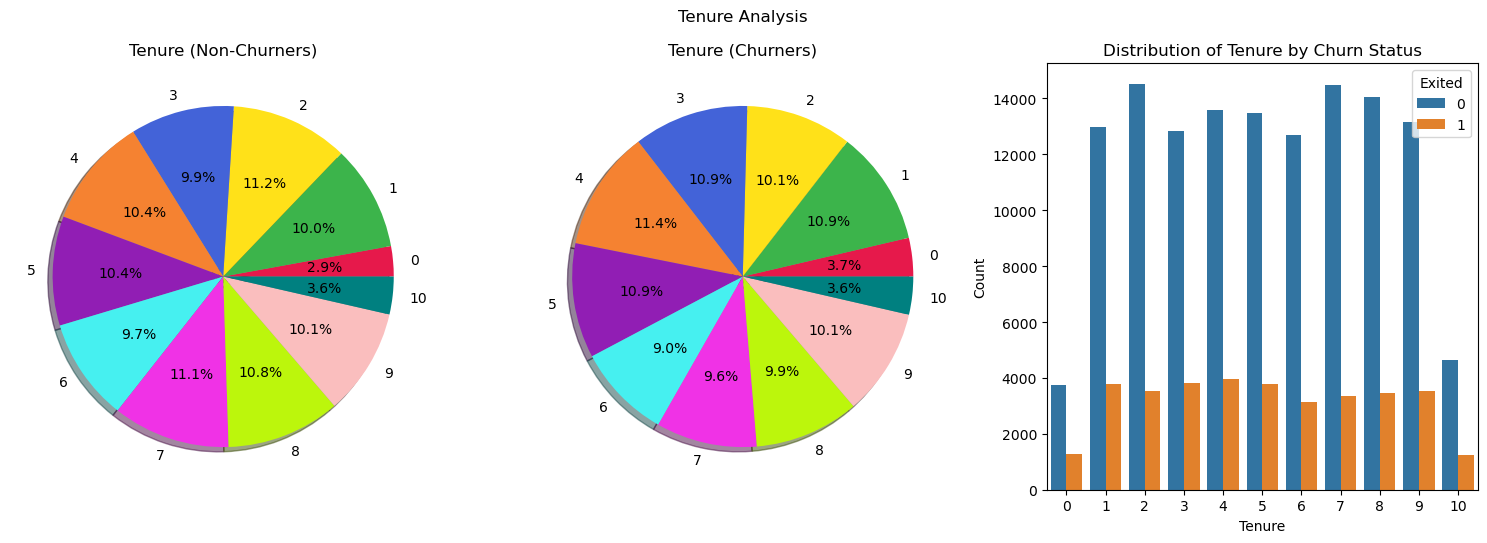

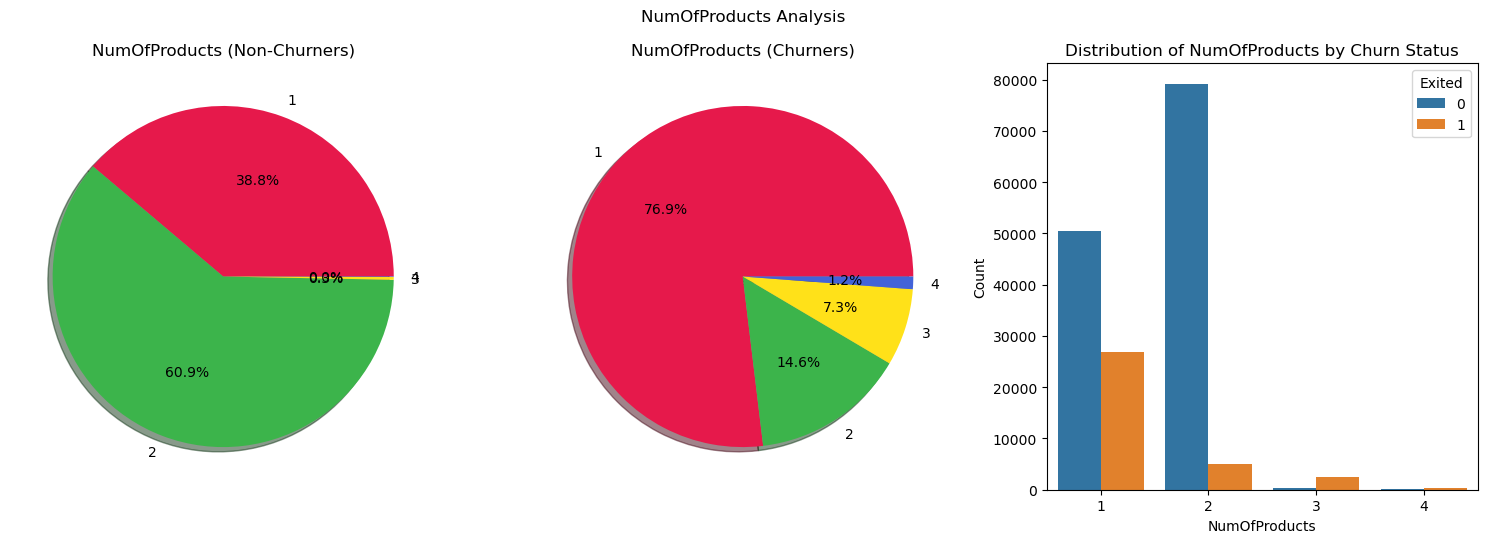

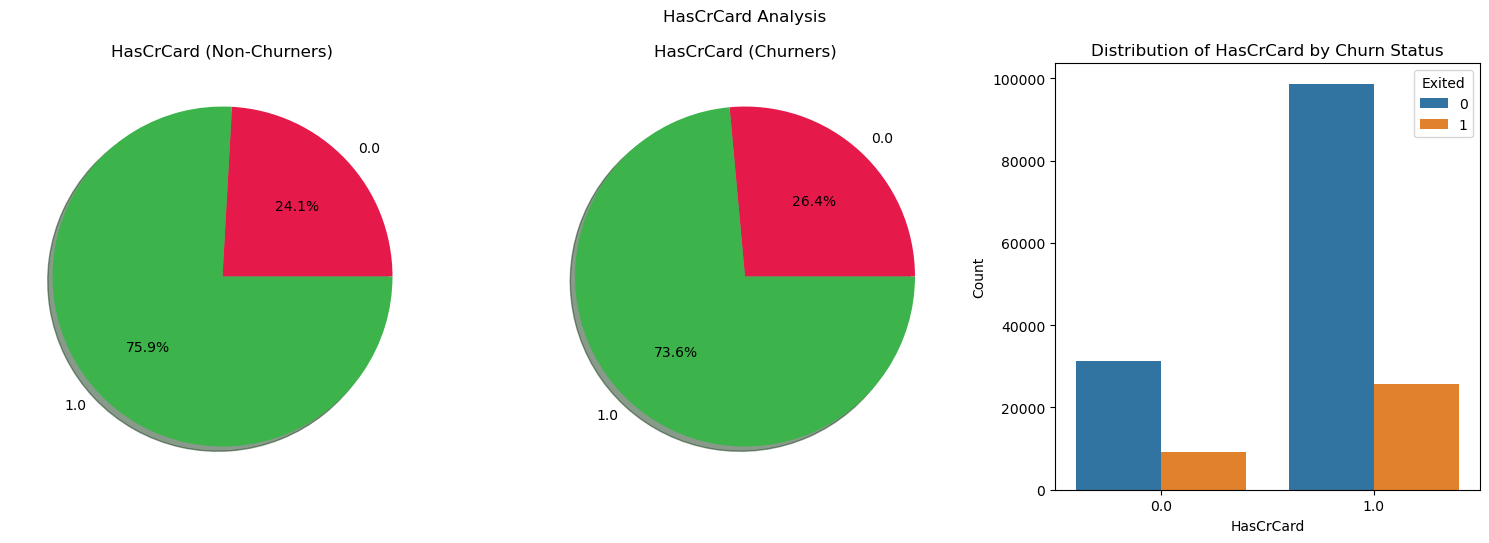

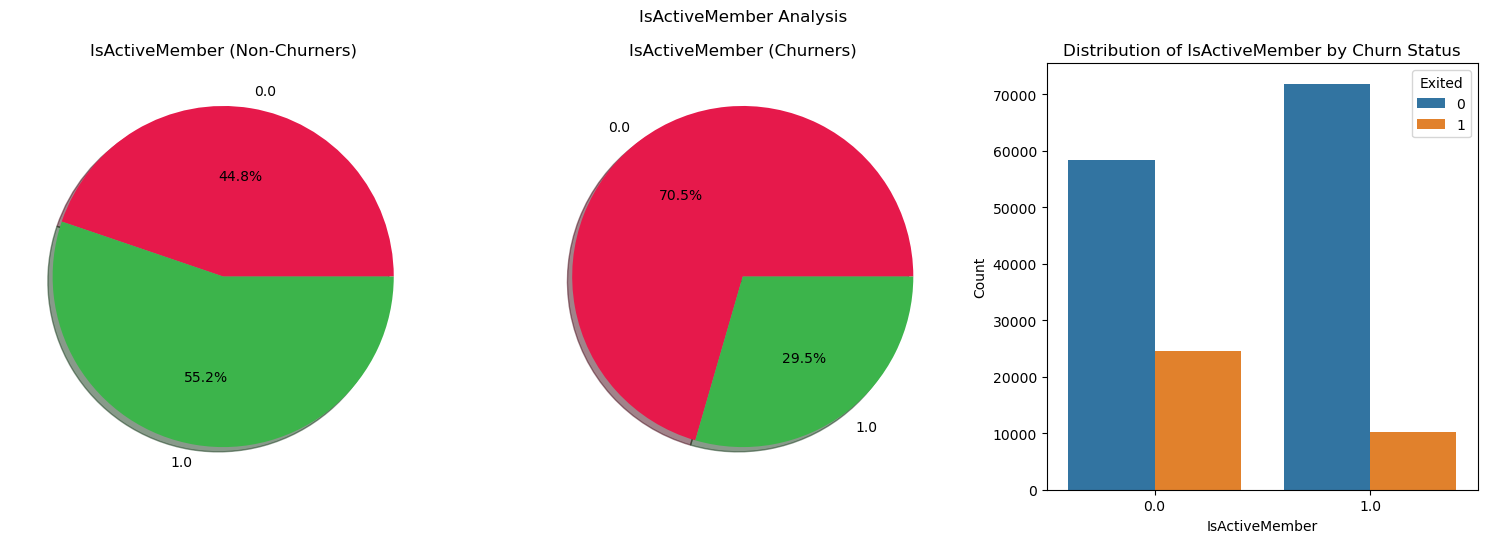

In [9]:
# Subset the features by type
numeric_features = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical_features = ['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
target_variable = 'Exited'

# Define a unique color palette for the pie charts with 11 distinct colors
pie_chart_palette = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
                     '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080']

for column in categorical_features:
    f, ax = plt.subplots(1, 3, figsize=(15, 5.5))
    
    # Get unique categories and sort them to ensure consistent color assignment
    unique_categories = sorted(data[column].unique())
    
    # Map each category to a color
    category_color_map = {category: pie_chart_palette[i] for i, category in enumerate(unique_categories)}
    
    # Distribution of the categorical variable for non-churners
    non_churners = data[data['Exited'] == 0]
    non_churners_counts = non_churners[column].value_counts().sort_index()
    non_churners_colors = [category_color_map[category] for category in non_churners_counts.index]
    non_churners_counts.plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True, colors=non_churners_colors)
    ax[0].set_ylabel('')
    ax[0].set_title(f'{column} (Non-Churners)')
    
    # Distribution of the categorical variable for churners
    churners = data[data['Exited'] == 1]
    churners_counts = churners[column].value_counts().sort_index()
    churners_colors = [category_color_map[category] for category in churners_counts.index]
    churners_counts.plot.pie(autopct='%1.1f%%', ax=ax[1], shadow=True, colors=churners_colors)
    ax[1].set_ylabel('')
    ax[1].set_title(f'{column} (Churners)')
    
    # Count plot for distribution of the categorical variable by 'Exited'
    # Using a different set of colors for the bar chart to distinguish from the pie charts
    sns.countplot(x=column, hue='Exited', data=data, ax=ax[2], palette=['#1f77b4', '#ff7f0e'])
    ax[2].set_title(f'Distribution of {column} by Churn Status')
    ax[2].set_ylabel('Count')
    
    plt.suptitle(f'{column} Analysis')
    plt.tight_layout()
    plt.show()

### Histogram

The histograms allow us to compare the distribution of each numerical feature for churners (orange bars) and non-churners (blue bars) side by side, identifying potential risk zones or thresholds where customers are more or less likely to churn. The `hue` parameter is set to `Exited` to compare distributions by churn status, `stat='percent'` normalizes the y-axis for easier comparison across features, and `kde=True` overlays a kernel density estimate for clearer visualization of underlying distributions, especially for continuous variables.

In [73]:
def plot_histogram_churn(data, column, title, discrete=False, kde=True):
    fig, ax = plt.subplots(figsize=(10, 6))
    data_copy = data.copy()
    data_copy['Exited'] = data_copy['Exited'].astype('category').cat.rename_categories({0: 'Not Churn', 1: 'Churn'})
    bool_cols = ['HasCrCard', 'IsActiveMember']

    if column == 'NumOfProducts':
        bin_edges = range(int(min(data[column])) - 1, int(max(data[column])) + 2)
        bin_locations = range(int(min(data[column])), int(max(data[column])) + 1)
    elif column in bool_cols:
        bin_edges = [-0.5, 0.5, 1.5]  # Centered at 0 and 1
        bin_locations = [0, 1]
    else:
        bin_edges, bin_locations = None, None

    if bin_locations is not None:
        sns.histplot(data=data_copy, x=column, hue='Exited', kde=kde, stat='percent', common_norm=False, discrete=discrete, bins=bin_edges)
        ax.set_xticks(bin_locations)
        ax.set_xticklabels(bin_locations)
    else:
        sns.histplot(data=data_copy, x=column, hue='Exited', kde=kde, stat='percent', common_norm=False, discrete=discrete)

    ax.set_title(f'Comparative Percentage Distribution of {title} by Customer Churn Status', fontsize=14)
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Percentage', fontsize=14)
    
    plt.show()

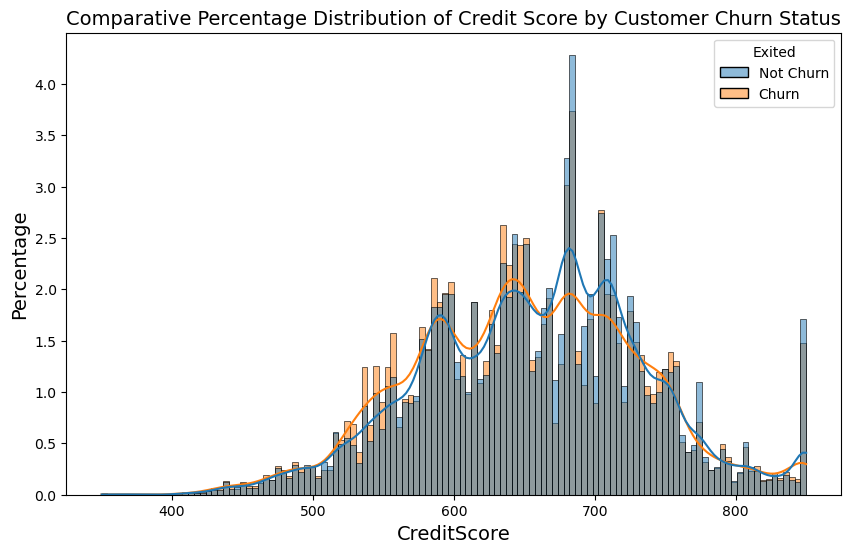

In [74]:
plot_histogram_churn(data, 'CreditScore', 'Credit Score', discrete=False, kde=True)

By comparing the relative heights of the orange and blue bars across different credit score ranges, you can identify potential risk zones or credit score thresholds where customers are more or less likely to churn. This information can be valuable for targeted retention efforts, customer segmentation, and feature engineering. 

 If the orange bars (representing churners) are taller than the blue bars (representing non-churners) in a particular credit score range, it indicates that customers within that credit score range have a higher propensity to churn or close their accounts.

 Conversely, if the blue bars are taller than the orange bars in a specific credit score range, it suggests that customers within that credit score range are less likely to churn and tend to remain as customers.

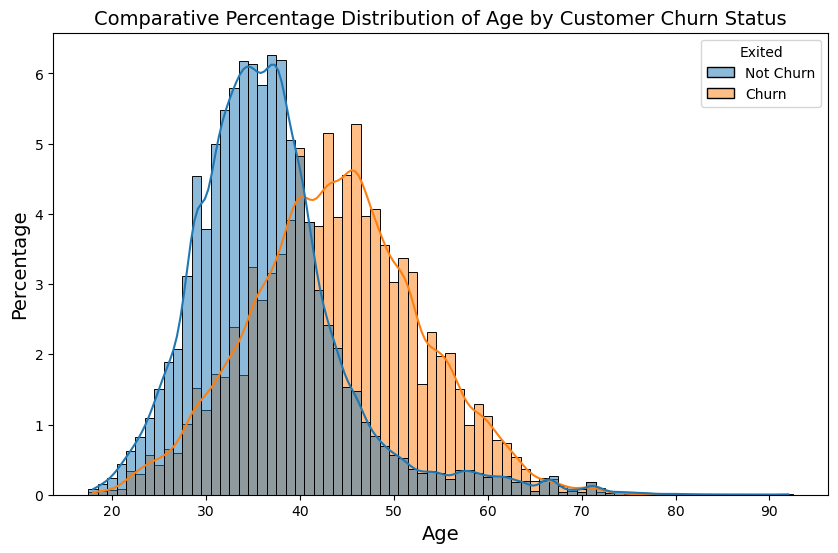

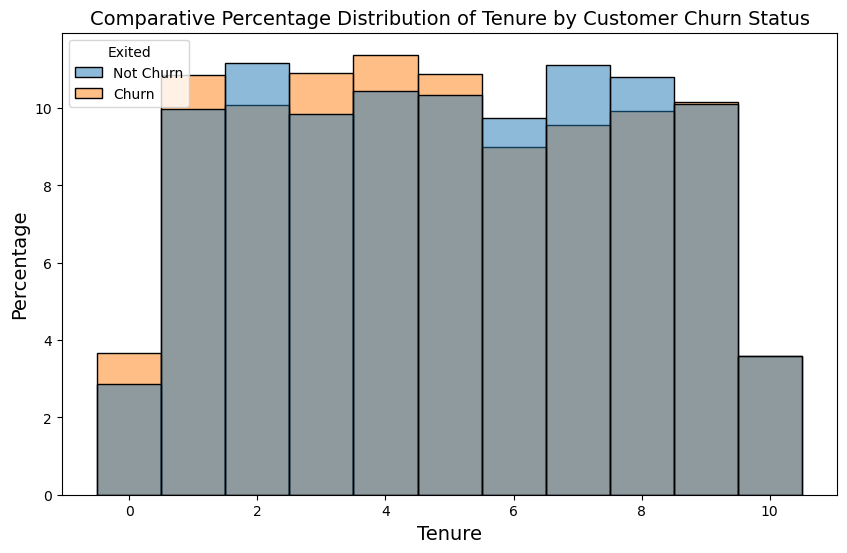

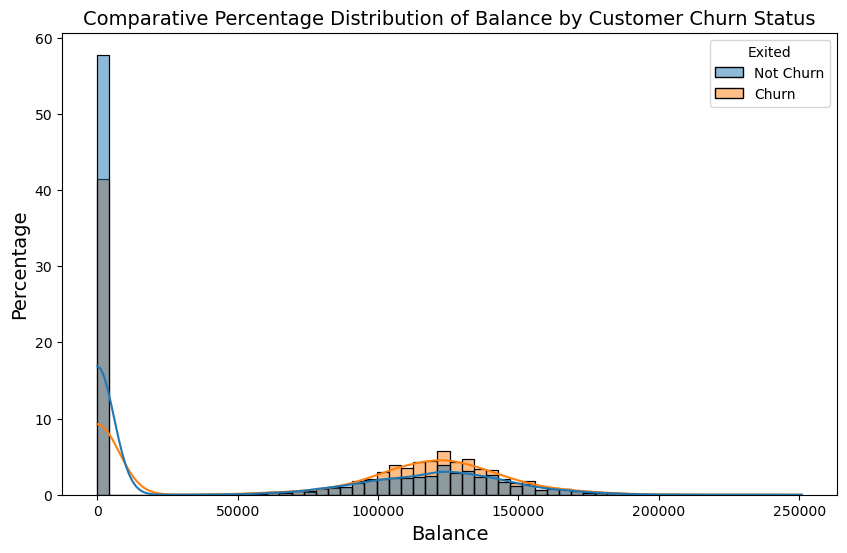

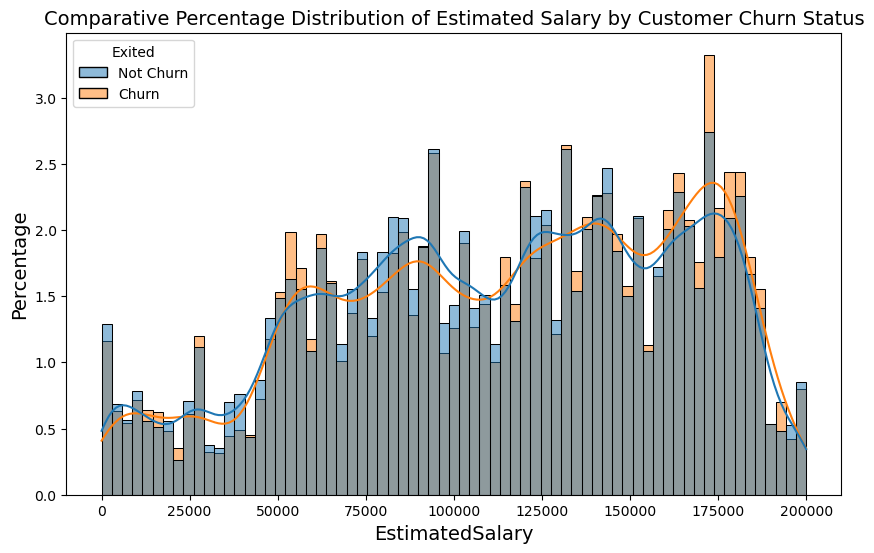

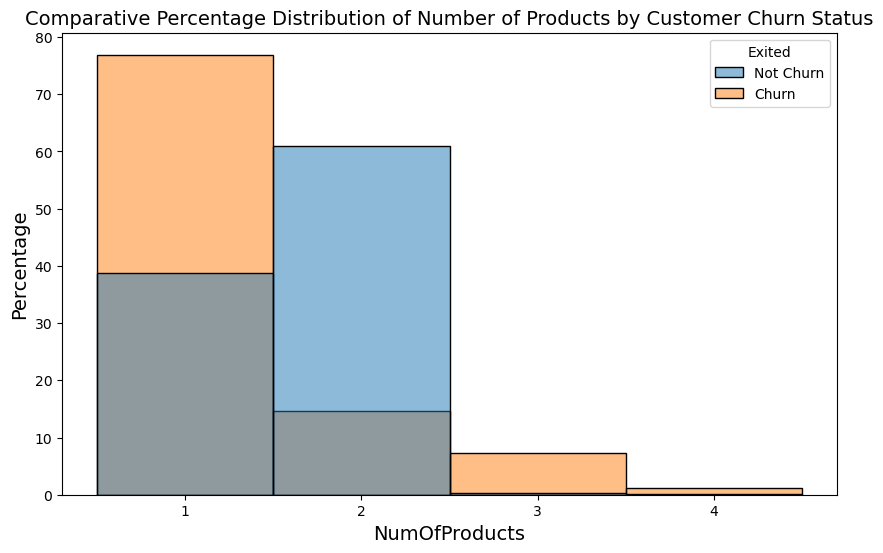

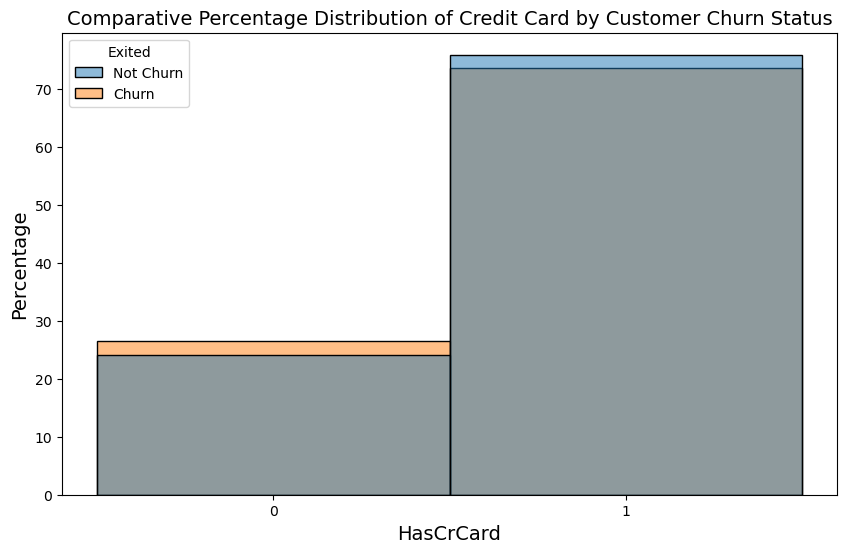

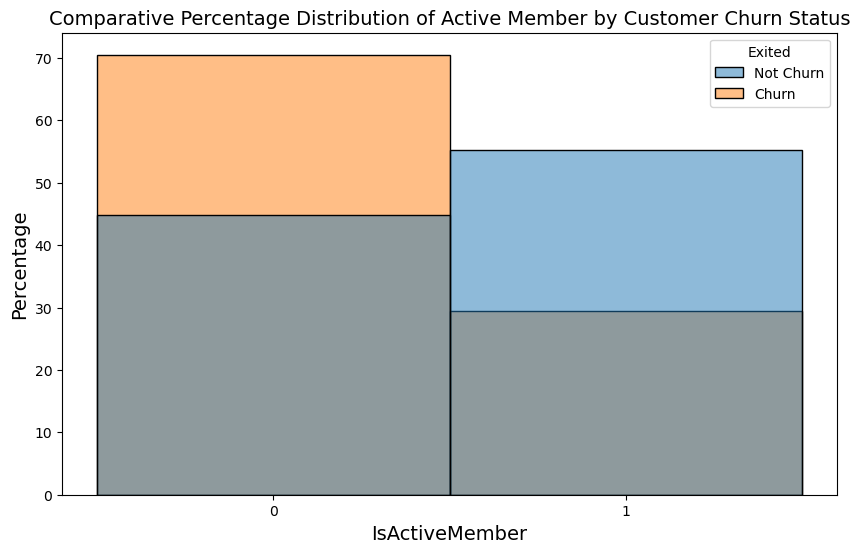

In [75]:
# Plot histograms for each numeric feature
plot_histogram_churn(data, 'Age', 'Age', discrete=True, kde=True)
plot_histogram_churn(data, 'Tenure', 'Tenure', discrete=True, kde=False)
plot_histogram_churn(data, 'Balance', 'Balance', discrete=False, kde=True)
plot_histogram_churn(data, 'EstimatedSalary', 'Estimated Salary', discrete=False, kde=True)
plot_histogram_churn(data, 'NumOfProducts', 'Number of Products', discrete=True, kde=False)
plot_histogram_churn(data, 'HasCrCard', 'Credit Card', discrete=True, kde=False)
plot_histogram_churn(data, 'IsActiveMember', 'Active Member', discrete=True, kde=False)



### Pair Plots

Visualizing with pair plots can help us visualize the distribution of single variables and relationships between two variables. The diagonal shows the distribution of the variable with respect to churn, while the off-diagonals show scatter plots for variable interactions.



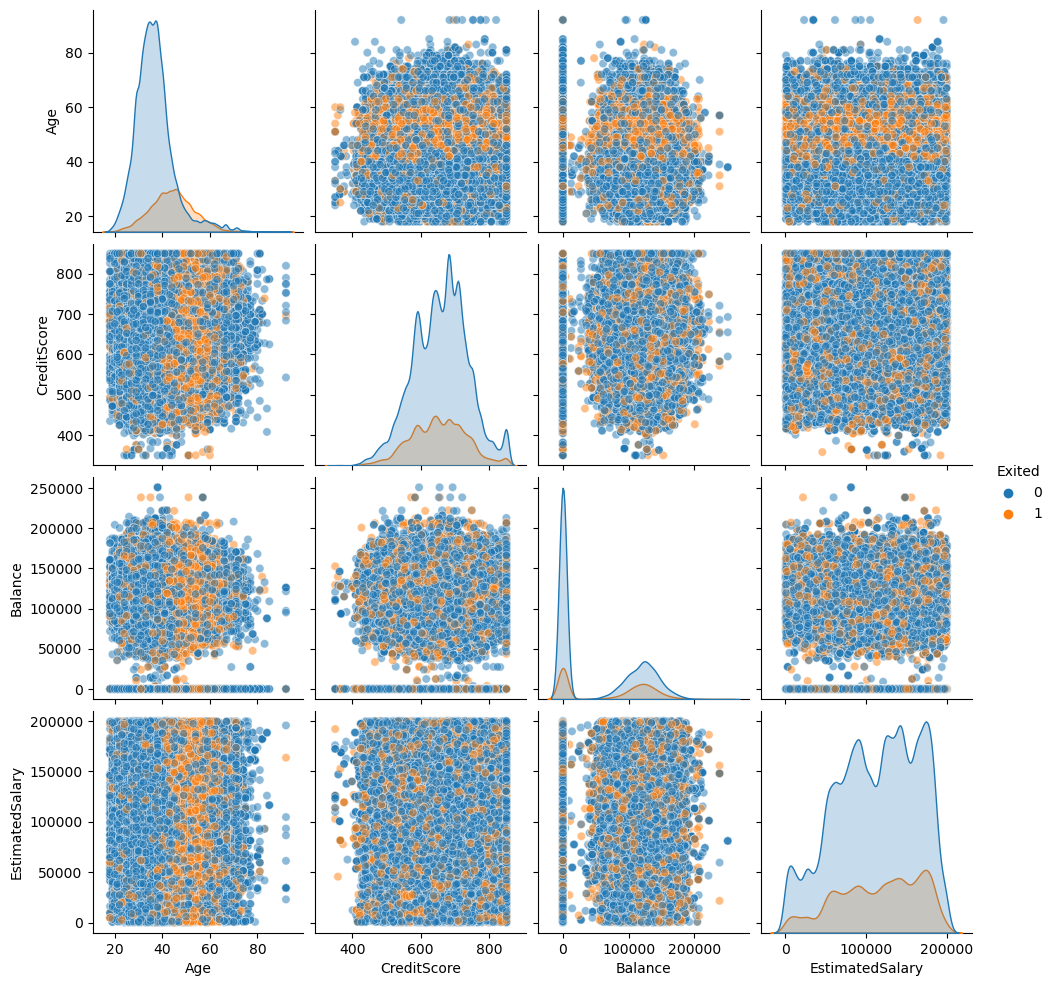

In [77]:
pair_plot_features = numeric_features + ['Exited']

# Create the pair plot
sns.pairplot(data[pair_plot_features], hue='Exited', plot_kws={'alpha': 0.5})
plt.show()


### Heatmap of Correlation Coefficients

A heatmap can visualize the correlation between features, including how each feature individually correlates with churn. This doesn't show direct interactions but can hint at potential relationships.

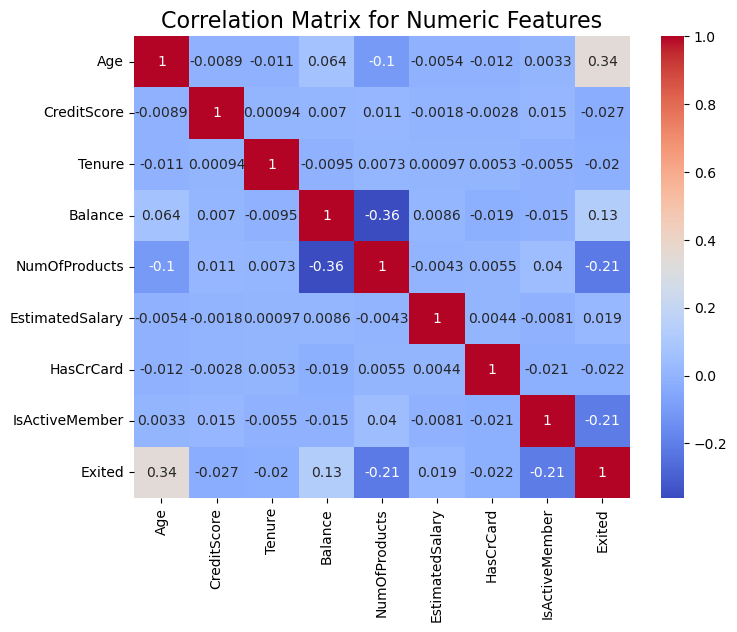

In [22]:
# Create a correlation matrix for numeric features
corr_matrix = data[numeric_features + ['Exited']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numeric Features', fontsize=16)
plt.show()

## Handling class imbalances

Class Distribution:
0: 130113 (78.8%)
1: 34921 (21.2%)


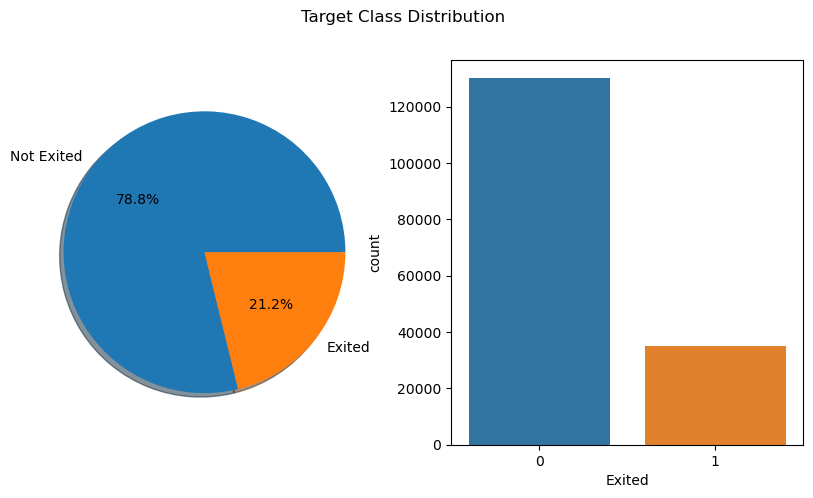

In [61]:
# Calculate class distribution
class_counts = data['Exited'].value_counts()
total_count = len(data)

print("Class Distribution:")
for cls, count in class_counts.items():
    proportion = (count / total_count) * 100
    print(f"{cls}: {count} ({proportion:.1f}%)")


fig, ax = plt.subplots(1, 2, figsize=(10, 5))

data['Exited'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True, labels=['Not Exited', 'Exited'])
ax[0].set_ylabel('')
sns.countplot(x='Exited', data=data, ax=ax[1])

plt.suptitle('Target Class Distribution')
plt.show()

This distribution reveals an imbalance in our dataset, with the majority class (non-churners) representing nearly 79% of the observations, while the minority class (churners) accounts for only 21.2%.

Class imbalance is a common challenge in many real-world classification problems, and it can have significant implications for our data science decisions and modeling approaches. Here's why:

1. **Biased Model Performance**: If we train a classification model on this imbalanced dataset without any adjustments, the model is likely to be biased towards the majority class (non-churners). This is because the model will tend to optimize for overall accuracy, which can be achieved by simply predicting the majority class for most instances. However, this approach may result in poor performance in identifying the minority class (churners), which is often the class of greater interest and importance.

2. **Skewed Evaluation Metrics**: Evaluation metrics like accuracy can be misleading when dealing with imbalanced datasets. For example, if our model predicts all instances as non-churners, it would achieve an accuracy of 78.8%, which may seem reasonable at first glance. However, this model would completely fail to identify any churners, rendering it useless for our purposes.

3. **Potential for Overfitting**: When training on imbalanced datasets, models may overfit to the majority class, leading to poor generalization performance on unseen data, especially for the minority class instances.

To address these challenges and ensure our models are effective in identifying potential churners, we need to consider various techniques and strategies:

1. **Resampling Techniques**: Methods like oversampling the minority class (e.g., SMOTE) or undersampling the majority class can help balance the class distribution in our training data. This can improve the model's ability to learn patterns from both classes effectively.

2. **Evaluation Metric Selection**: Instead of relying solely on accuracy, we should consider using evaluation metrics that are more appropriate for imbalanced datasets, such as precision, recall, F1-score, or area under the ROC curve (AUC-ROC). These metrics provide a more comprehensive assessment of the model's performance on both classes.

3. **Ensemble Methods**: Techniques like bagging, boosting, or stacking can help mitigate the effects of class imbalance by combining multiple models trained on different subsets or variations of the data.

By addressing the class imbalance in our dataset, we can develop more robust and effective models for predicting customer churn. This, in turn, will enable us to make more informed decisions regarding customer retention strategies, targeted interventions, and resource allocation.

## Modeling

### Predicting Customer Churn with Logistic Regression (baseline model)

In this section, we'll build a Logistic Regression model to predict customer churn for a bank. 

To prepare the data for modeling, we first split the dataset into feature variables (`X`) and the target variable (`y`), which represents whether a customer has churned or not. We then split the data into training and validation sets, ensuring that our model is evaluated on unseen data.

Next, we define the preprocessing steps for the dataset. We handle both numeric and categorical features separately, using `StandardScaler` to standardize the numeric feature (Age) and `OneHotEncoder` to encode the categorical features (IsActiveMember and NumOfProducts). These three features were the most relevant features for predicting churn based on our EDA.

To address the class imbalance in the dataset, where the number of churned customers (minority class) is much smaller than the non-churned customers (majority class), we employ the Synthetic Minority Over-sampling Technique (SMOTE). SMOTE generates synthetic examples of the minority class, helping the model learn more effectively from the underrepresented class.

We then define the Logistic Regression model and create a pipeline that includes the preprocessor, SMOTE, and the Logistic Regression classifier. We use GridSearchCV to perform a hyperparameter search, exploring different values for the regularization strength (`C`) and the optimization algorithm (`solver`). This allows us to find the best combination of hyperparameters for our model.

Finally, we evaluate the performance of the best Logistic Regression model on the validation set. We generate a confusion matrix, a classification report, the ROC AUC score, and the ROC curve to assess the model's ability to accurately predict customer churn. These evaluation metrics provide valuable insights into the model's strengths and weaknesses, guiding us towards further improvements or the exploration of alternative models.


Best parameters: {'classifier__C': 10, 'classifier__solver': 'saga'}
Best ROC AUC score: 0.8539040796518295


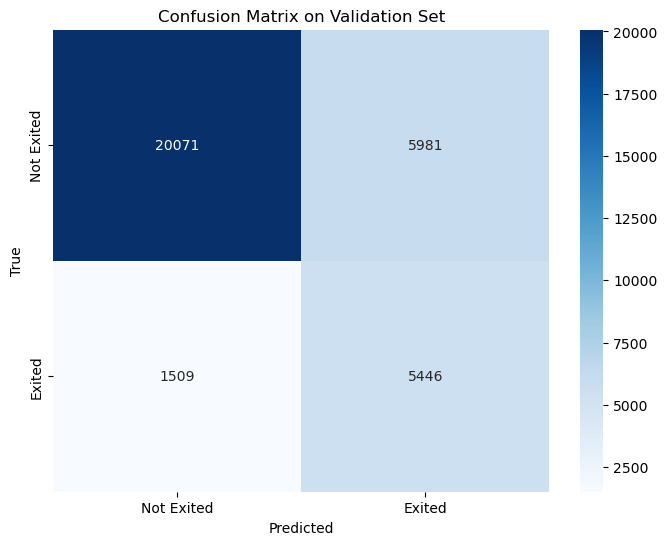

              precision    recall  f1-score       support
0              0.930074  0.770421  0.842753  26052.000000
1              0.476591  0.783034  0.592536   6955.000000
accuracy       0.773078  0.773078  0.773078      0.773078
macro avg      0.703332  0.776727  0.717644  33007.000000
weighted avg   0.834519  0.773078  0.790029  33007.000000
ROC AUC on validation set: 0.8546


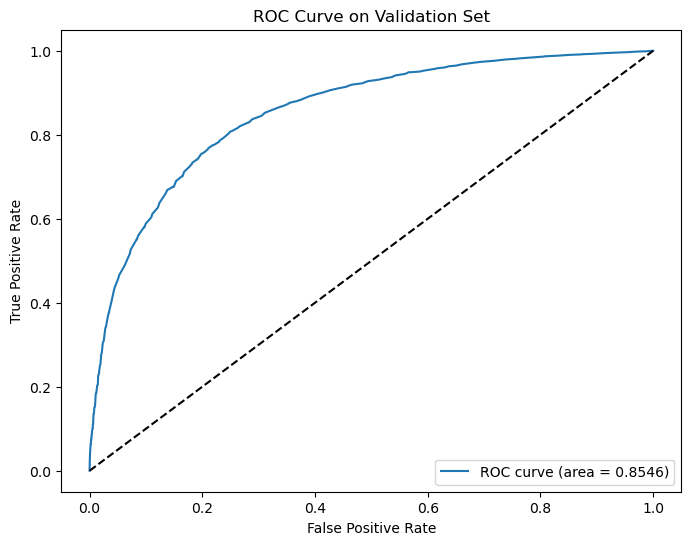

In [16]:
# Split the data into features and target
X = data[['Age', 'NumOfProducts', 'IsActiveMember']]
y = data['Exited']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the preprocessing for numeric columns (Age is numeric)
numeric_features = ['Age']
numeric_transformer = StandardScaler()

# Define the preprocessing for categorical columns (IsActiveMember and NumOfProducts are considered categorical)
categorical_features = ['IsActiveMember', 'NumOfProducts']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the base model and pipeline with SMOTE for handling class imbalance
model = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Define the parameter grid to search
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the model using grid search on the training set
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Best ROC AUC score achieved on the validation set
print("Best ROC AUC score:", grid_search.best_score_)

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (LR Baseline) on Validation Set')
plt.show()

# Classification Report
report = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# ROC AUC Score on the validation set
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC AUC (LR Baseline) on validation set: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Validation Set')
plt.legend(loc='lower right')
plt.show()

### Random Forest

### Optimizing Random Forest Hyperparameters

In this section, we'll use Bayesian optimization to find the best hyperparameters for a Random Forest model to predict customer churn.

First, we split the dataset into feature variables (`X`) and the target variable (`y`). We then define a preprocessing pipeline (`full_preprocessor`) that handles both numeric and categorical features using `StandardScaler` and `OneHotEncoder`, respectively. We'll be using all of the features in the dataset to begin with, while optimizing for the max number of features in our hyperparameter.

Next, we define a function `rf_cv` that takes in the hyperparameters for the Random Forest model (max_depth, min_samples_split, min_samples_leaf, max_features) and returns the mean ROC AUC score from a 5-fold cross-validation. This function ensures that the hyperparameters passed to the `RandomForestClassifier` are integers.

Inside the `rf_cv` function, we create a pipeline that includes the preprocessor, SMOTE for handling class imbalance, and the Random Forest classifier. We then perform the cross-validation and return the mean ROC AUC score.

We define the parameter bounds for the Bayesian optimization and create a `BayesianOptimization` object. We then run the optimization process, which will explore different combinations of the hyperparameters and find the best set that maximizes the ROC AUC score.

Finally, we print the best hyperparameters found by the Bayesian optimization process. These optimized hyperparameters will be used to train the final Random Forest model for predicting customer churn.

In [17]:
# Split features and target
X = data.drop('Exited', axis=1)
y = data['Exited']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for the entire dataset
full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'CreditScore', 'Tenure', 'Balance', 'EstimatedSalary']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember', 'NumOfProducts'])
    ])

# Define the function to optimize
def rf_cv(max_depth, min_samples_split, min_samples_leaf, max_features):
    # Ensure the parameters passed to RandomForestClassifier are integers
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    max_features = int(max_features)
    
    # Define the model
    model = RandomForestClassifier(
        n_estimators=100, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion='gini',
        n_jobs=-1,
        random_state=42
    )
    
    # Create the pipeline
    pipeline = ImbPipeline(steps=[
        ('preprocessor', full_preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    
    # Return the mean ROC AUC score from cross-validation
    return np.mean(cv_scores)

# Define the parameter bounds
pbounds = {
    'max_depth': (2, 15),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'max_features': (1, 8),  
}

# Instantiate BayesianOptimization object
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=pbounds,
    random_state=42,
)

# Perform optimization
optimizer.maximize(init_points=2, n_iter=10)

# Print the best parameters found
print(optimizer.max)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.8819    | 6.869     | 7.655     | 3.196     | 6.789     |
| 2         | 0.8681    | 4.028     | 2.092     | 1.174     | 8.929     |
| 3         | 0.8819    | 6.957     | 7.506     | 3.053     | 6.971     |
| 4         | 0.8845    | 12.8      | 8.0       | 3.958     | 6.373     |
| 5         | 0.883     | 15.0      | 4.47      | 1.0       | 2.0       |
| 6         | 0.8817    | 15.0      | 8.0       | 1.0       | 10.0      |
| 7         | 0.8815    | 15.0      | 1.0       | 4.0       | 7.466     |
| 8         | 0.8855    | 10.24     | 8.0       | 1.0       | 2.0       |
| 9         | 0.8817    | 15.0      | 8.0       | 4.0       | 2.0       |
| 10        | 0.8836    | 10.05     | 3.565     | 4.0       | 2.0       |
| 11        | 0.8538    | 2.0       | 8.0       | 1.0       | 2.0       |
| 12        | 0.8815    | 15.0      | 

### Random Forest Model Evaluation

In this section, we take the best hyperparameters found during the Bayesian optimization process and use them to define the final Random Forest model.

First, we extract the best hyperparameters from the Bayesian optimization results and convert them to their appropriate data types (integers).

We then create the final Random Forest model using the best hyperparameters and include it in an `ImbPipeline` along with the preprocessor and SMOTE for handling class imbalance.

Next, we fit the final pipeline on the training data (`X_train`, `y_train`) to train the Random Forest model.

To evaluate the model's performance, we use the final pipeline to make predictions on the validation set (`X_val`). We generate a confusion matrix, a classification report, the ROC AUC score, and the ROC curve to assess the model's ability to accurately predict customer churn.

The confusion matrix provides a visual representation of the model's true positive, true negative, false positive, and false negative predictions. The classification report gives detailed metrics, such as precision, recall, F1-score, and support for each class.

The ROC AUC score is a widely used metric for evaluating binary classification models, as it captures the model's ability to distinguish between the two classes. The ROC curve plots the true positive rate against the false positive rate, allowing you to assess the model's performance at different decision thresholds.

These evaluation metrics give you a comprehensive understanding of the Random Forest model's strengths and weaknesses in predicting customer churn, guiding us towards further model improvements or the exploration of alternative approaches.

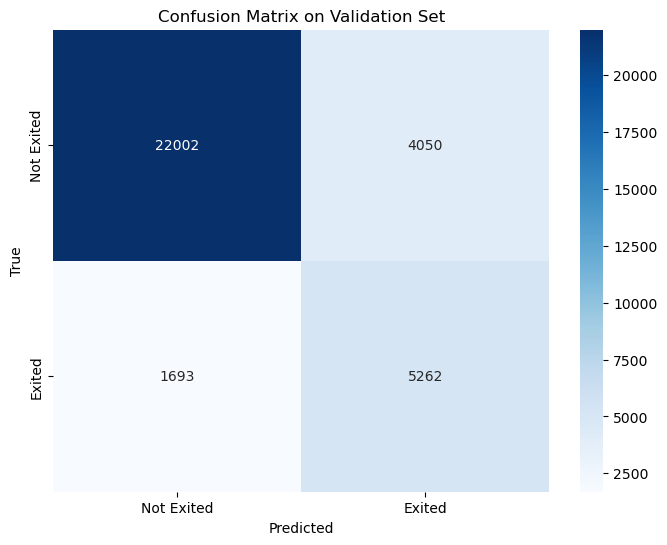

              precision    recall  f1-score       support
0              0.928550  0.844542  0.884556  26052.000000
1              0.565077  0.756578  0.646954   6955.000000
accuracy       0.826007  0.826007  0.826007      0.826007
macro avg      0.746814  0.800560  0.765755  33007.000000
weighted avg   0.851962  0.826007  0.834490  33007.000000
ROC AUC on validation set: 0.8869


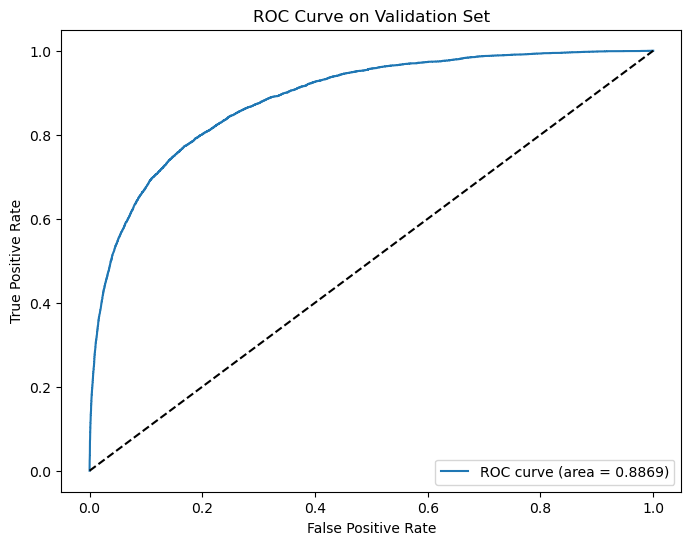

In [19]:
# Extract the best parameters for the random forest
best_rf_params = optimizer.max['params']

# Convert parameters to their appropriate types
best_rf_params['max_depth'] = int(best_rf_params['max_depth'])
best_rf_params['min_samples_split'] = int(best_rf_params['min_samples_split'])
best_rf_params['min_samples_leaf'] = int(best_rf_params['min_samples_leaf'])
best_rf_params['max_features'] = int(best_rf_params['max_features'])

# Define the model with the best parameters
best_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=best_rf_params['max_features'],
    criterion='gini',
    n_jobs=-1,
    random_state=42
)

# Create the pipeline with SMOTE and the best model
final_rf_pipeline = ImbPipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_rf_model)
])

# Fit the pipeline on the training set
final_rf_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_pred = final_rf_pipeline.predict(X_val)
y_pred_proba = final_rf_pipeline.predict_proba(X_val)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Classification Report
report = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# ROC AUC Score on the validation set
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC AUC on validation set: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Validation Set')
plt.legend(loc='lower right')
plt.show()

### XGBoost

In this section, we define a function `xgb_cv` that takes in the hyperparameters for the XGBoost model and returns the mean ROC AUC score from a 5-fold cross-validation. This function creates an `ImbPipeline` that includes the preprocessor, SMOTE, and the XGBoost classifier, and then performs the cross-validation.

Next, we define the parameter bounds for the Bayesian optimization, including hyperparameters such as `max_depth`, `min_child_weight`, `subsample`, `colsample_bytree`, `learning_rate`, `gamma`, `reg_alpha`, and `reg_lambda`. We then create a `BayesianOptimization` object and run the optimization process to find the best combination of hyperparameters.

After the optimization is complete, we extract the best hyperparameters found and use them to define the final XGBoost model. We create a new `ImbPipeline` that includes the preprocessor, SMOTE, and the XGBoost classifier with the best hyperparameters.

We then fit the final pipeline on the training data (`X_train`, `y_train`) and use it to make predictions on the validation set (`X_val`). To evaluate the model's performance, we generate a confusion matrix, a classification report, the ROC AUC score, and the ROC curve, similar to the evaluation of the Random Forest model.

In [24]:
def xgb_cv(max_depth, min_child_weight, subsample, colsample_bytree, learning_rate, gamma, reg_alpha, reg_lambda):
    max_depth = int(max_depth)
    
    model = xgb.XGBClassifier(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    pipeline = ImbPipeline(steps=[
        ('preprocessor', full_preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
    
    return cv_scores.mean()

In [26]:
pbounds = {
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 5),  # Minimum loss reduction required to make a further partition on a leaf node
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'min_child_weight': (1, 6),
    'reg_alpha': (0, 1),  # L1 regularization term on weights
    'reg_lambda': (1, 5),  # L2 regularization term on weights
    'subsample': (0.5, 1.0)
}

optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8857    | 0.6873    | 4.754     | 0.2223    | 7.191     | 1.78      | 0.156     | 1.232     | 0.9331    |
| 2         | 0.8847    | 0.8006    | 3.54      | 0.01597   | 9.789     | 5.162     | 0.2123    | 1.727     | 0.5917    |
| 3         | 0.8866    | 0.6521    | 2.624     | 0.1353    | 5.039     | 4.059     | 0.1395    | 2.169     | 0.6832    |
| 4         | 0.886     | 0.728     | 3.926     | 0.06791   | 6.6       | 3.962     | 0.04645   | 3.43      | 0.5853    |
| 5         | 0.8856    | 0.5325    | 4.744     | 0.29      | 8.659     | 2.523     | 0.09767   | 3.737     | 0.7201    |
| 6         | 0.873     | 0.5       | 2.609     | 0.01      | 3.0       | 2.891     | 0.5639    | 3.16      | 0.7042    |
| 7         | 0.886     

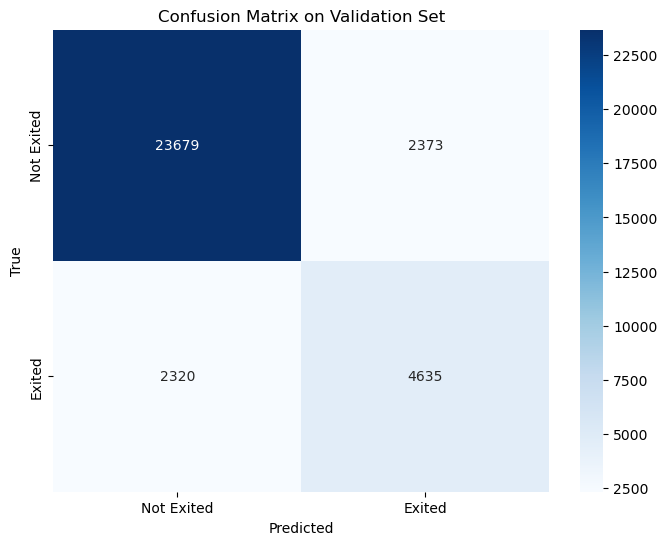

              precision    recall  f1-score       support
0              0.910766  0.908913  0.909838  26052.000000
1              0.661387  0.666427  0.663897   6955.000000
accuracy       0.857818  0.857818  0.857818      0.857818
macro avg      0.786076  0.787670  0.786868  33007.000000
weighted avg   0.858218  0.857818  0.858015  33007.000000
ROC AUC on validation set: 0.8891


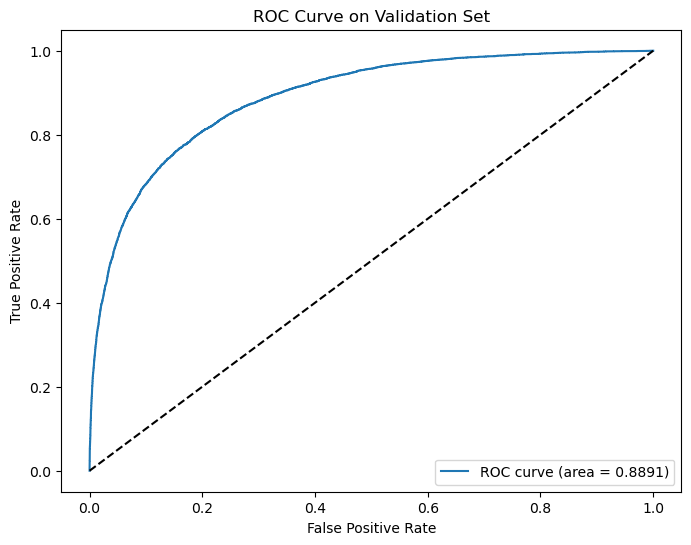

In [27]:
# Extract the best parameters for XGBoost
best_xgb_params = optimizer.max['params']

# Convert max_depth to integer
best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])

# Define the XGBoost model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    **best_xgb_params,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Create the pipeline with SMOTE and the best XGBoost model
final_pipeline = ImbPipeline(steps=[
    ('preprocessor', full_preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', best_xgb_model)
])

# Fit the pipeline on the training set
final_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_pred = final_pipeline.predict(X_val)
y_pred_proba = final_pipeline.predict_proba(X_val)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Classification Report
report = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# ROC AUC Score on the validation set
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"ROC AUC on validation set: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Validation Set')
plt.legend(loc='lower right')
plt.show()

## Conclusion

In this notebook, we explored a binary classification problem to predict customer churn for a bank. We started with a baseline Logistic Regression model and then implemented more advanced techniques like Random Forest and XGBoost, leveraging ensemble methods and hyperparameter optimization.

The key takeaways are:

1. **Handling Class Imbalance**: We employed the Synthetic Minority Over-sampling Technique (SMOTE) to address the class imbalance in the dataset, where the number of churned customers (minority class) was much smaller than the non-churned customers (majority class).

2. **Hyperparameter Optimization**: We used Bayesian optimization to find the best hyperparameters for both the Random Forest and XGBoost models, maximizing their performance on the validation set.

3. **Model Performance**: The XGBoost model achieved the highest ROC AUC score of 0.8891 on the validation set, outperforming the Random Forest model (0.8869) and the baseline Logistic Regression model (0.8546).

4. **Model Evaluation**: We evaluated the models using various metrics, including confusion matrices, classification reports, ROC AUC scores, and ROC curves, providing insights into their strengths and weaknesses in predicting customer churn.

Based on the results, the XGBoost model with optimized hyperparameters and SMOTE for handling class imbalance emerged as the best-performing model for predicting customer churn in this dataset. However, it's essential to consider the trade-offs between model complexity and interpretability, as well as the specific business requirements, when selecting the final model for deployment.